# DataStream Class - Jupyter Notebook Guide

This notebook demonstrates the usage of the `DataStream` class, which provides methods for analyzing time-series data.
The `DataStream` class provides various utilities for handling time series data, performing statistical analysis, and estimating different metrics like mean, uncertainty, confidence intervals, and effective sample size (ESS). Below is a breakdown of the functionality for each method of the DataStream class, including how to call them and their expected outputs applied to a GX data.



### Features:
- **Trimming**: Identifies steady-state regions in data.
- **Statistical Analysis**: Computes mean, standard deviation, confidence intervals, and cumulative statistics.
- **Stationarity Testing**: Uses the Augmented Dickey-Fuller test.
- **Effective Sample Size (ESS)**: Estimates the independent sample size.
- **Optimal Window Size**: Determines the best window for data smoothing.


## 1. Import Required Libraries

In [48]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

# Now we can import DataStream
import quends as qnds

## 2.  Load Data into DataStream Object
A `DataStream`object can be initialized with a **Pandas DataFrame, netcdf, numpy arrays, csv files, json**.

### CGYRO Data Analysis

In [49]:
# Specify the file paths
nu0_02 = "cgyro/output_nu0_02.csv" 
nu0_05 = "cgyro/output_nu0_05.csv" 
nu0_10 = "cgyro/output_nu0_10.csv"
nu0_50 = "cgyro/output_nu0_50.csv"
nu1_0 = "cgyro/output_nu1_0.csv"

In [50]:
# Load Data
data_stream_nu0_02 = qnds.from_csv(nu0_02)
data_stream_nu0_05 = qnds.from_csv(nu0_05)
data_stream_nu0_10 = qnds.from_csv(nu0_10)
data_stream_nu0_50 = qnds.from_csv(nu0_50)
data_stream_nu1_0 = qnds.from_csv(nu1_0)

## 3. Basic Data Exploration

### 3.1 Viewing first Few Rows

In [51]:
data_stream_nu0_50.head()

,Unnamed: 0,time,Q_D/Q_GBD,Q_e/Q_GBD
0,0,0.5,0.003355,0.001669
1,1,1.0,0.003314,0.003338
2,2,1.5,0.003160,0.003941
3,3,2.0,0.002480,0.002337
4,4,2.5,0.002004,0.001941


### 3.2 Listing Available Variables 

In [52]:
# Get available variables
data_stream_nu0_50.variables()

Index(['Unnamed: 0', 'time', 'Q_D/Q_GBD', 'Q_e/Q_GBD'], dtype='object')

### 3.3 Check length of DataStream

In [53]:
# Get the number of rows
len(data_stream_nu0_50)

1748

## 4. Data Processing

### VIsualize Data Trace

![Image Description](std.ke.nu0.50.k1.0-flux-v-time-1.png)

### Trace plot

#### $Q_e$|$Q_{GBD}$ Variable

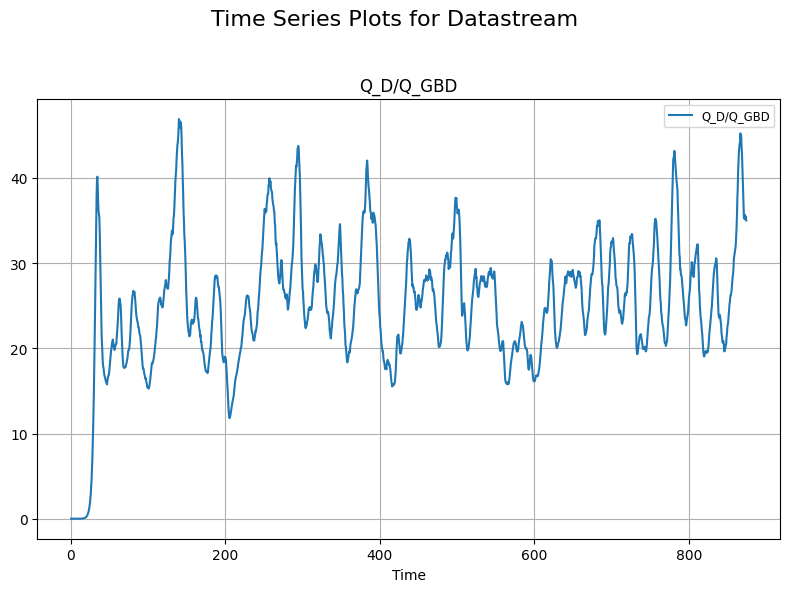

In [54]:
plotter=qnds.Plotter()
plotter.trace_plot(data_stream_nu0_50,["Q_D/Q_GBD"])

### 4.1 Stationarity Check

The is_stationary() method checks whether the specified columns in the data stream are stationary by performing the Augmented Dickey-Fuller (ADF) test.

In [55]:
# Check if multiple columns are stationary
data_stream_nu0_50.is_stationary(["Q_D/Q_GBD", "Q_e/Q_GBD"])


{'Q_D/Q_GBD': True, 'Q_e/Q_GBD': True}

### 4.2 Trimming data based to obtain steady-state portion

The trim() method is used to trim the data from the steady-state point based on a chosen method. 

Expected Output:
- This will return a new DataStream object containing only the data from the steady-state point onward.

**Trim based on the standard deviation approach**

In [56]:
# Trim the data based on standard deviation method
trimmed_df = data_stream_nu0_50.trim(column_name="Q_D/Q_GBD", window_size = 10, method='std')
# View trimmed data
trimmed_df.head()

,time,Q_D/Q_GBD
0,208.0,12.974854
1,208.5,13.264263
2,209.0,13.563313
3,209.5,13.815548
4,210.0,14.046638


#### Plot of the trace together with the start of the steady state

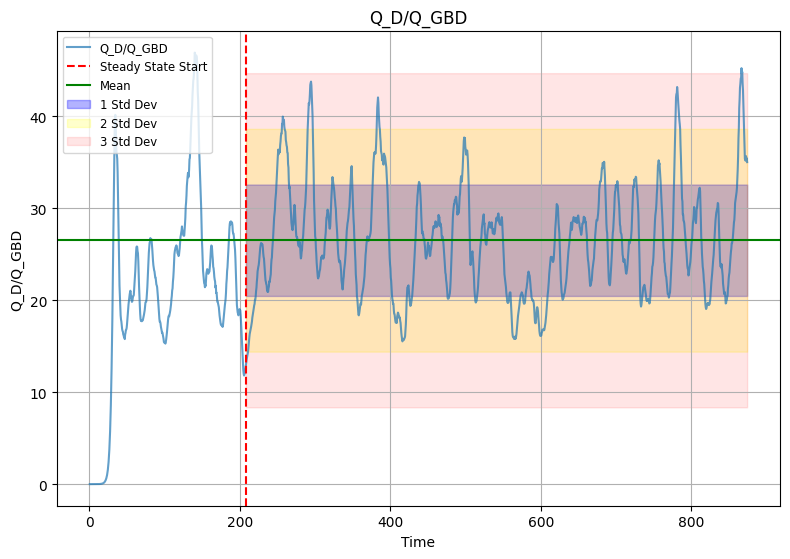

In [57]:
plotter.steady_state_automatic_plot(data_stream_nu0_50,["Q_D/Q_GBD"])

### $Q_e$|$Q_{GBD}$ Variable

In [58]:
# Trim the data based on standard deviation method
trimmed_ds_ = data_stream_nu0_50.trim(column_name="Q_e/Q_GBD", window_size = 10, method='std')
# View trimmed data
trimmed_ds_.head()

,time,Q_e/Q_GBD
0,343.0,13.006512
1,343.5,13.136017
2,344.0,13.317713
3,344.5,13.663731
4,345.0,13.823589


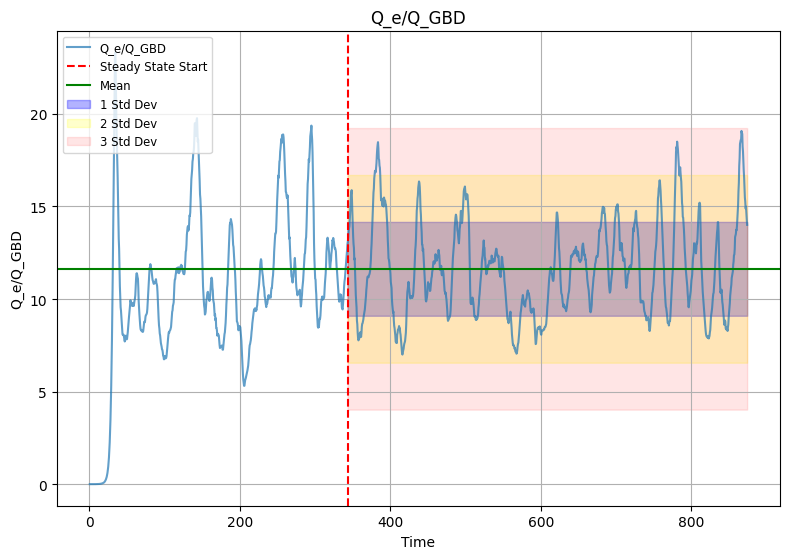

In [59]:
plotter.steady_state_automatic_plot(data_stream_nu0_50,["Q_e/Q_GBD"])

### 4.3 Autocorrelation Plot

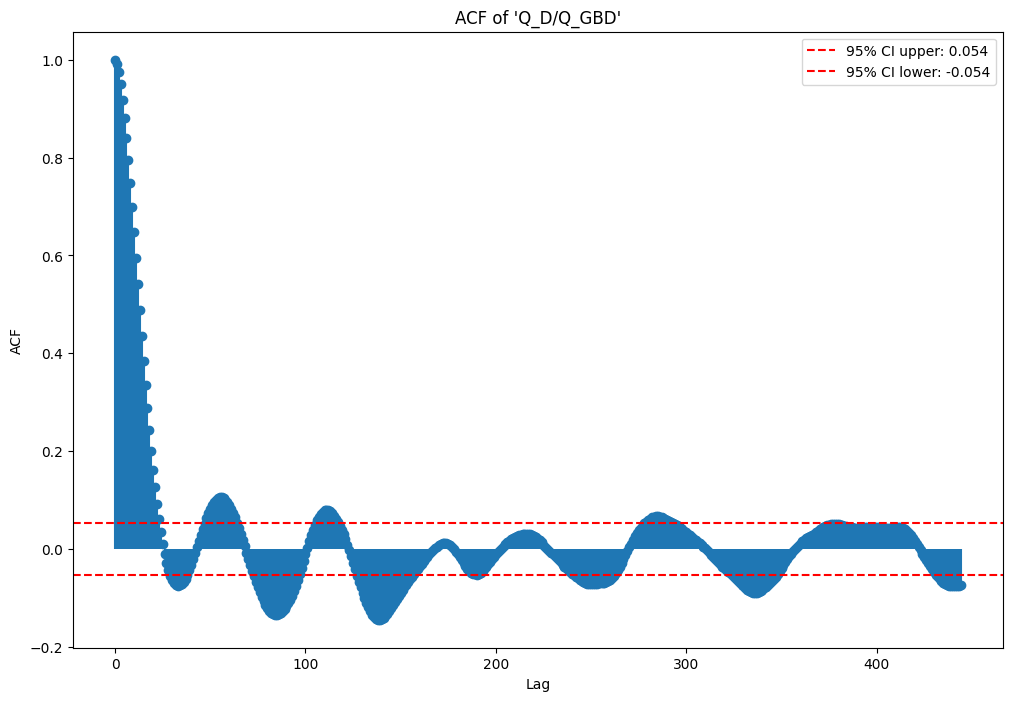

In [60]:
plotter.plot_acf(trimmed_df)

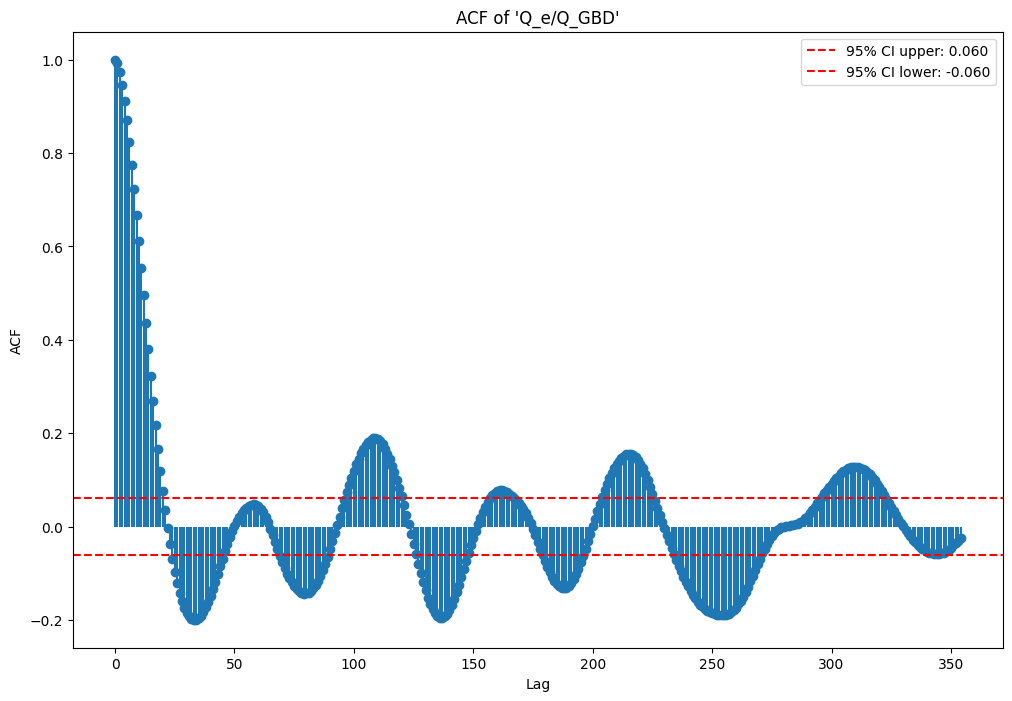

In [61]:
plotter.plot_acf(trimmed_ds_)

### 4.4 Effective Sample Size
The ESS can be computed using the following formula:


$$ESS = \frac{n}{1 + 2 \sum_{k=1}^{K} \rho(k)}$$
Where:
- $n$ is the total sample size.
- $\rho(k)$ is the autocorrelation at lag $k$.
- $K$ is a truncation point where $\rho(k)$ is considered small enough to be considered ignored (insignificant)

**effective_sample_size:** In this function, it directly identifies the lags where the absolute ACF exceeds the critical value (95% CI). These are treated as the "significant" lags and their absolute ACF values are summed up for ESS calculation.

In [62]:
ess_df = trimmed_df.effective_sample_size()
ess_df

{'Q_D/Q_GBD': 28}

In [63]:
ess_dict = trimmed_ds_.effective_sample_size(column_names = ["Q_e/Q_GBD"])
ess_dict

{'Q_e/Q_GBD': 16}

**effective_sample_size_below:** This function identifies the first lag at which the absolute ACF falls below a critical value (confidence interval). The lags before this drop are considered "significant," and their absolute ACF values are summed up for ESS calculation.

In [64]:
ess_df = trimmed_df.effective_sample_size_below()
ess_df


{'Q_D/Q_GBD': 51}

In [65]:
ess_df = trimmed_ds_.effective_sample_size_below()
ess_df

{'Q_e/Q_GBD': 44}

## 5. UQ Analysis

### 5.1 Mean Estimation

The mean() method calculates the mean of the short-term averages for a specified column, using either the sliding window or non-overlapping method.

#### Using non-overlapping method 

In [66]:
mean_df = trimmed_df.mean(window_size=10)
mean_df

{'Q_D/Q_GBD': {'mean': 26.525258060399572}}

In [67]:
mean_df = trimmed_ds_.mean(window_size=10)
mean_df

{'Q_e/Q_GBD': {'mean': 11.609959405308876}}

#### Using sliding Window method 

In [68]:
mean_df_s = trimmed_df.mean(method="sliding")
mean_df_s

{'Q_D/Q_GBD': {'mean': 26.485931761077083}}

In [69]:
mean_df_s = trimmed_ds_.mean(method="sliding")
mean_df_s

{'Q_e/Q_GBD': {'mean': 11.527607618295065}}

### 5.2 Estimate Mean Uncertainty

The mean_uncertainty() method computes the uncertainty (standard error) of the mean for short-term averages.

In [70]:
uq_df = trimmed_df.mean_uncertainty()
uq_df

{'Q_D/Q_GBD': {'mean uncertainty': 0.3564504737003372}}

In [71]:
uq_df = trimmed_df.mean_uncertainty(method="sliding")
uq_df

{'Q_D/Q_GBD': {'mean uncertainty': 0.3555104298351744}}

In [72]:
uq_df_e = trimmed_ds_.mean_uncertainty()
uq_df_e

{'Q_e/Q_GBD': {'mean uncertainty': 0.16178777442730263}}

In [73]:
uq_df_e = trimmed_ds_.mean_uncertainty(method="sliding")
uq_df_e

{'Q_e/Q_GBD': {'mean uncertainty': 0.16153431597666393}}

### 5.3 Estimate confidence interval

The confidence_interval() method computes the confidence interval for the mean of short-term averages.

In [74]:
ci_df = trimmed_df.confidence_interval()
ci_df

{'Q_D/Q_GBD': {'confidence interval': (25.727199462511397,
   27.124485319416717)}}

In [75]:
ci_df = trimmed_df.confidence_interval()
ci_df

{'Q_D/Q_GBD': {'confidence interval': (25.727199462511397,
   27.124485319416717)}}

In [76]:
ci_df_s = trimmed_ds_.confidence_interval()
ci_df_s

{'Q_e/Q_GBD': {'confidence interval': (11.21034084198846, 11.844548917743486)}}

### 5.4 Estimating Full Statistics

The compute_statistics() method calculates the mean, standard deviation, confidence interval, and plus-minus one (±1) standard deviation for short-term averages.

In [77]:
stats_non_overlap = trimmed_df.compute_statistics()
stats_non_overlap


{'Q_D/Q_GBD': {'mean': 26.425842390964057,
  'mean_uncertainty': 0.3564504737003372,
  'confidence_interval': (25.727199462511397, 27.124485319416717),
  'pm_std': (26.06939191726372, 26.782292864664395)}}

In [78]:
stats_non_overlap_slide = trimmed_df.compute_statistics(method="sliding")
stats_non_overlap_slide

{'Q_D/Q_GBD': {'mean': 26.485931761077083,
  'mean_uncertainty': 0.3555104298351744,
  'confidence_interval': (25.78913131860014, 27.182732203554025),
  'pm_std': (26.13042133124191, 26.841442190912257)}}

In [79]:
stats_non_overlap_e = trimmed_ds_.compute_statistics()
stats_non_overlap_e

{'Q_e/Q_GBD': {'mean': 11.527444879865973,
  'mean_uncertainty': 0.16178777442730263,
  'confidence_interval': (11.21034084198846, 11.844548917743486),
  'pm_std': (11.36565710543867, 11.689232654293276)}}

In [80]:
stats_non_overlap_slide_e = trimmed_ds_.compute_statistics(method="sliding")
stats_non_overlap_slide_e

{'Q_e/Q_GBD': {'mean': 11.527607618295065,
  'mean_uncertainty': 0.16153431597666393,
  'confidence_interval': (11.211000358980803, 11.844214877609327),
  'pm_std': (11.366073302318402, 11.689141934271728)}}

### 5.5 Optimal Window Size Selection

The optimal_window_size() method determines the optimal window size that minimizes the uncertainty (standard error) of the mean.

In [81]:
optimal_df = trimmed_df.optimal_window_size()
optimal_df

{'Q_D/Q_GBD': {'optimal_window_size': 6,
  'min_std': 0.16314207516371315,
  'mean': 26.528541443716193,
  'ci': (26.208782976395316, 26.84829991103707)}}

In [82]:
optimal_ds = trimmed_ds_.optimal_window_size()
optimal_ds

{'Q_e/Q_GBD': {'optimal_window_size': 6,
  'min_std': 0.0766853543963496,
  'mean': 11.621608751278247,
  'ci': (11.471305456661401, 11.771912045895093)}}

### 5.6 Additional Data to achieve some level of uncertainty reduction

The additional_data() method estimates how many additional samples (in time steps) are needed to reduce the uncertainty in the mean by a specified factor using a power-law SEM model.

In [83]:
addition_info = trimmed_df.additional_data(method="sliding",reduction_factor=0.1)
addition_info

{'Q_D/Q_GBD': {'A_est': 2.376475090920045,
  'p_est': 0.08416377237904193,
  'n_current': 1287,
  'current_sem': 1.3008265896454756,
  'target_sem': 1.170743930680928,
  'n_target': 4500.39460785471,
  'additional_samples': 3214}}

In [84]:
addition_info = trimmed_ds_.additional_data(method="sliding", reduction_factor=0.1)
addition_info

{'Q_e/Q_GBD': {'A_est': 0.810823869837706,
  'p_est': 0.08092117762201695,
  'n_current': 998,
  'current_sem': 0.4636960006603426,
  'target_sem': 0.41732640059430837,
  'n_target': 3669.34112030326,
  'additional_samples': 2672}}